# Multi-Species Models

Here, we give an explicit example for a model with multiple species, i.e. different site classes.

Another example is given by the [FermiHubbardModel2](https://tenpy.readthedocs.io/en/latest/reference/tenpy.models.hubbard.FermiHubbardModel2.html#fermihubbardmodel2).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150

In [2]:
import tenpy
from tenpy.networks.mps import MPS
from tenpy.models.model import CouplingMPOModel
from tenpy.networks import site

tenpy.tools.misc.setup_logging(to_stdout="INFO")

## Heisenberg chain + Fermions

As a first example, let us consider spinless fermions coupled to Spins with Heisenberg couplings via a density-Sz interaction, given by the Hamiltonian
$$
H = J \sum_{\langle i, j\rangle}  \vec{S}_i \cdot \vec{S}_{j} - t \sum_{\langle i, j\rangle} \left(c^\dagger_i c_j  + h.c.\right) + r \sum_i n_i S^z_i,
$$
where $S^x, S^y, S^z$ are the spin-1/2 operators and $c_x, c^\dagger_x, n_x = c^\dagger_x c_x$ are the fermionic operators.
For simplicity, we consider first a 1D ladder. In this case, the Jordan-Wigner transformation can be used to map the fermions to spins as well, but it is still instructive to see how defining the model with the different sites works.
Moreover, the Sz magnetization and fermion particle number are **conserved inependently** in this model. To incorporate this into TeNPy, we would need separate sites even if we map the fermions to spins.

Let us start by plotting the Ladder and couplings:

(-0.1, 4.0)

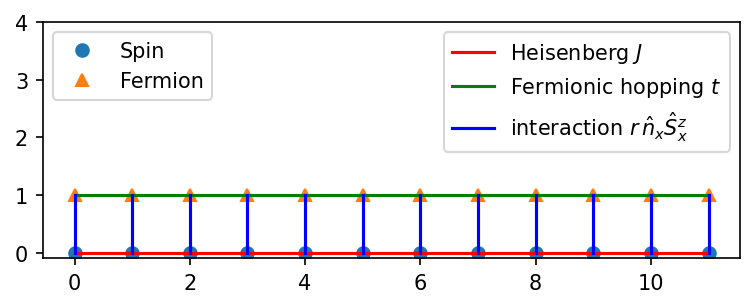

In [3]:
ladder = tenpy.models.lattice.Ladder(12, [None, None])
ax = plt.gca()
ladder.plot_sites(ax)
ladder.plot_coupling(ax, [(0, 0, 1)], color='r', label='Heisenberg $J$')
ladder.plot_coupling(ax, [(1, 1, 1)], color='g', label='Fermionic hopping $t$')
ladder.plot_coupling(ax, [(0, 1, 0)], color='b', label='interaction $r \, \hat{n}_x \hat{S}^z_x$')
ax.set_aspect(1.)
leg = ax.legend(loc='upper right')
ax.add_artist(leg)
leg2 = ax.legend(["Spin", "Fermion"], loc='upper left')
ax.set_ylim(-0.1, 4.)

In [4]:
class HeisenbergFermion1D_ladder(CouplingMPOModel):
    """Heisenberg chain coupled to fermions via n.Sz, see above."""
    
    default_lattice = "Ladder"
    force_default_lattice = True
    
    def init_sites(self, model_params):
        spin = site.SpinHalfSite(conserve='Sz')
        ferm = site.FermionSite(conserve='N')
        sites = [spin, ferm]
        site.set_common_charges(sites, new_charges='independent')
        return [spin, ferm]
    
    def init_terms(self, model_params):
        J = model_params.get('J', 1.)
        t = model_params.get('t', 1.)
        r = model_params.get('r', 0.1)
        # Heisenberg spin coupling
        self.add_coupling(J/2., 0, 'Sp', 0, 'Sm', [1], plus_hc=True)
        self.add_coupling(J, 0, 'Sz', 0, 'Sz', [1])
        # fermion hopping
        self.add_coupling(t, 1, 'Cd', 1, 'C', [1], plus_hc=True)
        # spin-fermion-interaction
        self.add_coupling(r, 0, 'Sz', 1, 'N', [0])
        
M1 = HeisenbergFermion1D_ladder({'L': 12})
L = M1.lat.Ls[0]

INFO    : HeisenbergFermion1D_ladder: reading 'L'=12


Note that we called `set_common_charges` in `init_sites` to make sure that the charges are compatible with each other. In fact, this has added trivial 0 charges of the fermions to the spins and vice versa:

In [5]:
print(M1.lat.unit_cell)
spin, ferm = M1.lat.unit_cell
print(spin.leg.chinfo)
assert spin.leg.chinfo == ferm.leg.chinfo
print("charges of Spin site:")
print(spin.leg)
print("charges of Fermion site:")
print(ferm.leg)

[SpinHalfSite('Sz'), FermionSite('N', 0.500000)]
ChargeInfo([1, 1], ['2*Sz', 'N'])
charges of Spin site:
 +1
0 [[-1  0] 
1  [ 1  0]]
2          
charges of Fermion site:
 +1
0 [[0 0] 
1  [0 1]]
2        


Due to the independent charge conservation, we need to fix the "fillings" of the charges separtely.
Say, for example, that we want 1/3 filling of the electrons, but the Sz=0 sector of the spins:

In [6]:
product_state = [(s,f) for s, f in zip(['up', 'down'] * 3, ['full', 'empty', 'empty'] * 2)]
print('product_state = ')
print(product_state)
psi = MPS.from_lat_product_state(M1.lat, product_state)

product_state = 
[('up', 'full'), ('down', 'empty'), ('up', 'empty'), ('down', 'full'), ('up', 'empty'), ('down', 'empty')]


We can calculate expectation values for the spins only, the fermions only, or both:

In [7]:
Szs = psi.expectation_value('Sz', sites=M1.lat.mps_idx_fix_u(0))
print("<Sz> =", Szs)

Ns = psi.expectation_value('N', sites=M1.lat.mps_idx_fix_u(1))
print("<N> =", Ns)

print(f"sum(<Sz>)={sum(Szs):.3f}, sum(<N>)={sum(Ns):.2f}")

both = psi.expectation_value(['Sz', 'N'])
assert np.allclose(both[0::2], Szs)
assert np.allclose(both[1::2], Ns)

<Sz> = [ 0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5  0.5 -0.5]
<N> = [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
sum(<Sz>)=0.000, sum(<N>)=4.00


Of course, we can also run DMRG. Since we only have "long-range" hopping over more than two sites in this case, it's important to turn enable the mixer.

In [8]:
eng = tenpy.algorithms.dmrg.TwoSiteDMRGEngine(psi, M1, {'mixer': True, 
                                                        'trunc_params': {'chi_max': 100}})
E, psi = eng.run()

INFO    : TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<1 options>, 'trunc_params')
INFO    : TwoSiteDMRGEngine: reading 'mixer'=True
INFO    : activate DensityMatrixMixer with initial amplitude 1.0e-05
INFO    : Running sweep with optimization
INFO    : trunc_params: reading 'chi_max'=100
INFO    : checkpoint after sweep 1
energy=-11.4788335021826562, max S=1.3028448076966368, age=24, norm_err=7.4e-01
Current memory usage 154.9MB, wall time: 1.8s
Delta E = nan, Delta S = 9.8382e-01 (per sweep)
max trunc_err = 3.1520e-11, max E_trunc = 9.6581e-12
chi: [1, 4, 8, 16, 22, 26, 30, 34, 34, 38, 34, 42, 38, 42, 42, 46, 44, 38, 32, 16, 8, 4, 2]
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 2
energy=-11.4906761572017153, max S=1.4780911857284140, age=24, norm_err=3.1e-02
Current memory usage 155.9MB, wall time: 2.7s
Delta E = -1.1843e-02, Delta S = 2.1231e-01 (per sweep)
max trunc_err = 9.6715e-08, max E_trunc = 3.0980e-07
chi: [2, 4, 8, 16, 32, 64, 100, 100, 

In [9]:
Szs = psi.expectation_value('Sz', sites=M1.lat.mps_idx_fix_u(0))
print("<Sz> =", Szs)

Ns = psi.expectation_value('N', sites=M1.lat.mps_idx_fix_u(1))
print("<N> =", Ns)

print(f"sum(<Sz>) = {sum(Szs):.3f}, sum(<N>) ={sum(Ns):.2f}")

both = psi.expectation_value(['Sz', 'N'])
assert np.allclose(both[0::2], Szs)
assert np.allclose(both[1::2], Ns)

<Sz> = [ 0.01023 -0.00897  0.0034  -0.00325 -0.00081 -0.0006  -0.0006  -0.00081 -0.00325  0.0034  -0.00897
  0.01023]
<N> = [0.21378 0.42372 0.33217 0.31519 0.38698 0.32815 0.32815 0.38698 0.31519 0.33217 0.42372 0.21378]
sum(<Sz>) = 0.000, sum(<N>) =4.00


Text(0, 0.5, 'entropy $S$')

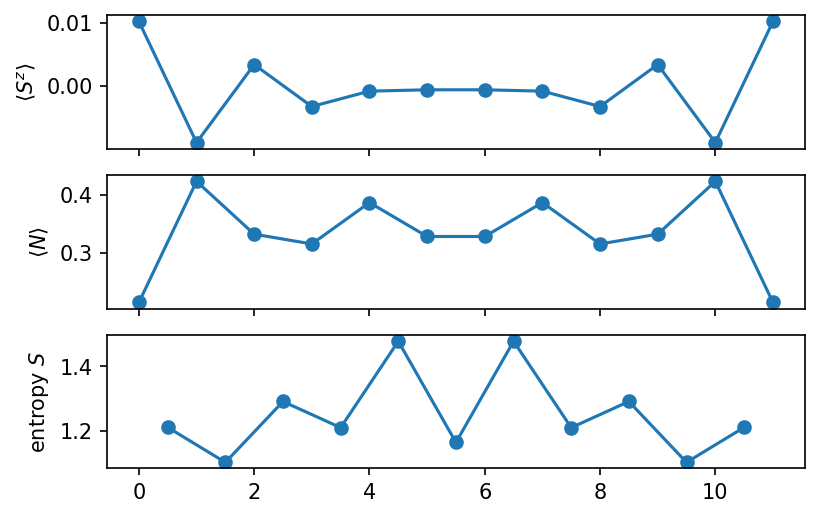

In [10]:
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(np.arange(L), Szs, 'o-')
axes[0].set_ylabel(r'$\langle S^z \rangle $')
axes[1].plot(np.arange(L), Ns, 'o-')
axes[1].set_ylabel(r'$\langle N \rangle $')
axes[2].plot(np.arange(0.5, L - 1), psi.entanglement_entropy(bonds=np.arange(2, 2*L -1, 2)), 'o-')
axes[2].set_ylabel('entropy $S$')

We can also implement the very same model by viewing it directly as a `Chain`, but with multiple species per site of the Chain. This can be implemented with the [MultiSpeciesLattice](https://tenpy.readthedocs.io/en/latest/reference/tenpy.models.lattice.MultiSpeciesLattice.html#tenpy.models.lattice.MultiSpeciesLattice). When using the `CouplingMPOModel`, we actually only have to change the return of `init_sites` to include the species names:

In [11]:
class HeisenbergFermion1D_multispecies(CouplingMPOModel):
    """Heisenberg chain coupled to fermions via n.Sz, see above."""
    
    default_lattice = "Chain"
    force_default_lattice = True
    
    def init_sites(self, model_params):
        spin = site.SpinHalfSite(conserve='Sz')
        ferm = site.FermionSite(conserve='N')
        sites = [spin, ferm]
        site.set_common_charges(sites, new_charges='independent')
        return [spin, ferm], ['s', 'f']  # return species names as well!
        # this causes `init_lattice` to initialize a `MultiSpeciesLattice`
    
    def init_terms(self, model_params):
        J = model_params.get('J', 1.)
        t = model_params.get('t', 1.)
        r = model_params.get('r', 0.1)
        # Heisenberg spin coupling
        self.add_coupling(J/2., 0, 'Sp', 0, 'Sm', [1], plus_hc=True)
        self.add_coupling(J, 0, 'Sz', 0, 'Sz', [1])
        # fermion hopping
        self.add_coupling(t, 1, 'Cd', 1, 'C', [1], plus_hc=True)
        # spin-fermion-interaction
        self.add_coupling(r, 0, 'Sz', 1, 'N', [0])
                
M1_multispecies = HeisenbergFermion1D_multispecies({'L': 12})

INFO    : HeisenbergFermion1D_multispecies: reading 'L'=12


In [12]:
# check that they actually have the same hamiltonian:
assert M1_multispecies.H_MPO.is_equal(M1.H_MPO)

This makes it easy to generalize the case to 2D as well.
Note that the `MultiSpeciesLattice` has coupling pairs ending with `_{species_name}`. Further, you can use the `onsite_species_pairs` for onsite couplings between different species:

In [13]:
class HeisenbergFermion2D(CouplingMPOModel):
    """Heisenberg chain coupled to fermions via n.Sz, see above."""
    
    def init_sites(self, model_params):
        spin = site.SpinHalfSite(conserve='Sz')
        ferm = site.FermionSite(conserve='N')
        sites = [spin, ferm]
        site.set_common_charges(sites, new_charges='independent')
        return [spin, ferm], ['spin', 'ferm']  # return species names as well!
        # this causes `init_lattice` to initialize a `MultiSpeciesLattice`
    
    def init_terms(self, model_params):
        J = model_params.get('J', 1.)
        t = model_params.get('t', 1.)
        r = model_params.get('r', 0.1)
        # Heisenberg spin coupling
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_spin-spin']:
            self.add_coupling(J/2., u1, 'Sp', u2, 'Sm', dx, plus_hc=True)
            self.add_coupling(J, u1, 'Sz', u2, 'Sz', dx)
        # fermion hopping
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_ferm-ferm']:
            self.add_coupling(t, u1, 'Cd', u2, 'C', dx, plus_hc=True)
        # "onsite" spin-fermion-interaction
        for u1, u2, dx in self.lat.pairs['onsite_spin-ferm']:
            self.add_coupling(r, u1, 'Sz', u2, 'N', dx)
        
M2 = HeisenbergFermion2D({'Lx': 2, 'Ly': 2, 'lattice': 'Honeycomb'})

INFO    : HeisenbergFermion2D: reading 'lattice'='Honeycomb'
INFO    : HeisenbergFermion2D: reading 'Lx'=2
INFO    : HeisenbergFermion2D: reading 'Ly'=2


In [14]:
print(M2.coupling_terms['Sz_i N_j'].to_TermList())

0.10000 * Sz_0 N_1 +
0.10000 * Sz_2 N_3 +
0.10000 * Sz_4 N_5 +
0.10000 * Sz_6 N_7 +
0.10000 * Sz_8 N_9 +
0.10000 * Sz_10 N_11 +
0.10000 * Sz_12 N_13 +
0.10000 * Sz_14 N_15


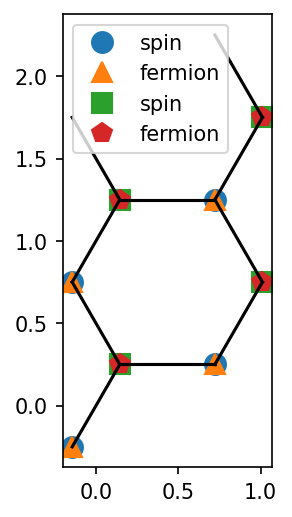

In [15]:
ax = plt.gca()
M2.lat.plot_sites(ax, labels=['spin', 'fermion'], markersize=10.)  
# sites are plotted on top of each other, since they are at the same space in the lattice
M2.lat.plot_coupling(ax, M2.lat.pairs['nearest_neighbors_ferm-ferm'])
ax.set_aspect(1.)
leg = ax.legend(loc='upper left')